![](./img/monthly_GRSM.png)

__Clik__ <a href=./map/network_GRSM_2018-08-02.html>map</a>

# Part 2: Code demo, an example of Glacier National Park

## 1. Data cleaning (not run)
- Input: 
    - SafeGraph pattern dataset downloaded at the state level (`MT.csv`)
    - Park boundary (`nps_boundary.shp`)
- Process: spatial subsetting, geocoding
- Results: 
    - Daily visiation time series of in-park POIs 
    - A GeoJSON file that contains these in-park POIs for subsequent analysis
    
```python
# Load data and convert dataframe to geodataframe using lon and lat columns
boundary = gpd.read_file('../raw_data/nps_boundary/nps_boundary.shp') # boundary shapefile
boundary = boundary.set_index('UNIT_CODE') 
df = pd.read_csv('../raw_data/SafeGraph/MT.csv') # safegraph data
gdf = gpd.GeoDataFrame(df, 
                       crs = "EPSG:4269",
                       geometry = gpd.points_from_xy(df.sg_c__longitude, df.sg_c__latitude))

# Geocode POIs with missing lot-lat info
gdf_na = gdf[gdf['geometry'].is_empty] 
gdf_na["address"] = gdf_na['sg_mp__street_address'] + ', ' +  gdf_na['sg_mp__city'] + ', ' + gdf_na['sg_mp__region'] + ' ' + gdf_na['sg_mp__postal_code'].astype(int).astype(str)gdf_na['sg_mp__postal_code'].astype(int).astype(str)
na_poi = gdf_na[['placekey', 'address']].drop_duplicates()
geo = geocode(na_poi['address'], provider='nominatim', user_agent = 'autogis_xx')
geo['geometry'].intersects(boundary.at[park, 'geometry']).sum() # check these POIs don't fall within park boundary, so disregard them

# Subset POIs located within the park boundary of Glacier NP
subset_gdf = gdf.loc[gdf['geometry'].intersects(boundary.at['GLAC', 'geometry'])]
subset_gdf = subset_gdf.dropna(subset = ['sg_mp__visits_by_day']) # drop NA in the daily visitation column due to data error

# Explode daily visitation column to multiple rows
subset_gdf.sg_mp__visits_by_day = subset_gdf.sg_mp__visits_by_day.apply(literal_eval) # convert from string to JSON list
subset_gdf = subset_gdf.explode('sg_mp__visits_by_day') # explode it vertically and have each row representing a day

# Create date column to indicate the exact date of year
subset_gdf['n_of_day'] = subset_gdf.groupby(['date_range_start','placekey']).cumcount()
subset_gdf['date_range_start'] = pd.DatetimeIndex(subset_gdf.date_range_start) # convert from string to date
subset_gdf['date'] = pd.DatetimeIndex(subset_gdf.date_range_start) + pd.to_timedelta(subset_gdf['n_of_day'], unit = 'd')

# save a subset of POIs as GeoJSON file.
subset_gdf.to_file('../clean_data/POI_GLAC.geojson', driver = 'GeoJSON')

```

## 2. Data validation
- Input: 
    - GeoJSON file that contains POIs found within the Glacier park boundary  (`GeoJSON`)
    - NPS monthly visitor counts (`nps_visit_2015_2021.csv`)
- Tasks: temporal aggregation, merging
- Results: 
    - A time series plot comparing two data sources
    - A density plot to gauge the spatial dynamics

In [2]:
# !pip install geoplot

In [1]:
import geopandas as gpd  
import pandas as pd
from geopandas.tools import geocode
from ast import literal_eval
import matplotlib.pyplot as plt
import geoplot
import osmnx as ox
import networkx as nx
from tqdm import tqdm, trange

Load the cleaned GeoJSON file:

In [6]:
# Load saved GeoJSON 
subset_gdf = gpd.read_file('./data/POI_GLAC.geojson')

# load park boundary
boundary = gpd.read_file('./data/nps_boundary.shp')
boundary = boundary.set_index('UNIT_CODE') 

# convert variable to propoer format
subset_gdf['date_range_start'] = pd.DatetimeIndex(subset_gdf.date_range_start) # convert to datetime
subset_gdf['sg_mp__visits_by_day'] = pd.to_numeric(subset_gdf['sg_mp__visits_by_day']) # convert to numeric

Aggreagate safegraph daily visitaiton to the park-month level: by `'date_range_start'`(column for year-month)

In [7]:
park_month = subset_gdf.groupby('date_range_start')['sg_mp__visits_by_day'].sum().to_frame()

Load NPS monthly visitor counts:

In [10]:
nps = pd.read_csv('./data/nps_visit_2015_2021.csv')
nps = nps[nps['UnitCode']  == 'GLAC'] # filter data for Glacier only
nps['RecreationVisits'] = nps['RecreationVisits'].str.replace(",", "").astype(float) # convert to numeric data
# Create a column to indicate year-month
nps['date'] = pd.to_datetime(nps[['Year', 'Month']].assign(DAY = 1))

**Merge** Safegraph monthly data to NPS visitation:

In [12]:
month_df = nps.set_index('date').join(park_month, how = 'inner') # Inner join by year-month column
month_df['sg_mp__visits_by_day'] = pd.to_numeric(month_df['sg_mp__visits_by_day']) # convert to numeric
month_df.head()

ParkName UnitCode       ParkType          Region State  Year  \
2018-01-01  Glacier NP     GLAC  National Park  Intermountain     MT  2018   
2018-02-01  Glacier NP     GLAC  National Park  Intermountain     MT  2018   
2018-03-01  Glacier NP     GLAC  National Park  Intermountain     MT  2018   
2018-04-01  Glacier NP     GLAC  National Park  Intermountain     MT  2018   
2018-05-01  Glacier NP     GLAC  National Park  Intermountain     MT  2018   

            Month  RecreationVisits NonRecreationVisits RecreationHours  ...  \
2018-01-01      1           12222.0                  14          49,913  ...   
2018-02-01      2           11847.0                  24          48,261  ...   
2018-03-01      3           21758.0                  18          90,075  ...   
2018-04-01      4           28404.0                  70         120,797  ...   
2018-05-01      5          195116.0                 375       1,012,270  ...   

           RecreationHoursTotal NonRecreationHoursTotal  \
2018-01-01           32,211,332                 118,373   
2018-02-01           32,211,332                 118,373   
2018-03-01           32,211,332                 118,373   
2018-04-01           32,211,332                 118,373   
2018-05-01           32,211,332                 118,373   

           ConcessionerLodgingTotal ConcessionerCampingTotal TentCampersTotal  \
2018-01-01                  107,156                        0          110,507   
2018-02-01                  107,156                        0          110,507   
2018-03-01                  107,156                        0          110,507   
2018-04-01                  107,156                        0          110,507   
2018-05-01                  107,156                        0          110,507   

           RVCampersTotal BackcountryTotal NonRecreationOvernightStaysTotal  \
2018-01-01        109,566           32,349                                0   
2018-02-01        109,566           32,349                                0   
2018-03-01        109,566           32,349                                0   
2018-04-01        109,566           32,349                                0   
2018-05-01        109,566           32,349                                0   

           MiscellaneousOvernightStaysTotal sg_mp__visits_by_day  
2018-01-01                            1,178                   71  
2018-02-01                            1,178                   61  
2018-03-01                            1,178                  137  
2018-04-01                            1,178                  168  
2018-05-01                            1,178                 1072  

[5 rows x 36 columns]

### 2.1 **Time series plot**: validate two datasets on the time dimension

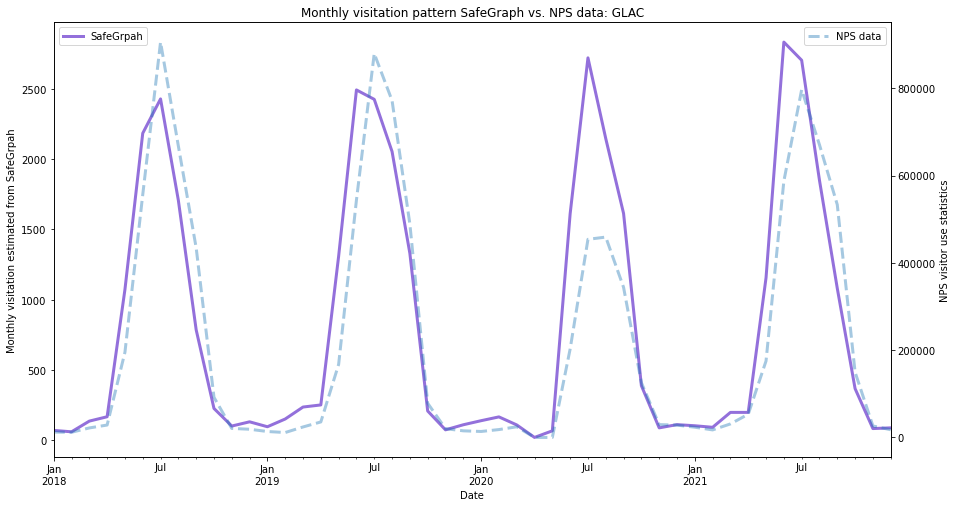

In [15]:
f, a = plt.subplots(figsize = (15, 8))
month_df['sg_mp__visits_by_day'].plot(ax = a, color = 'mediumpurple', label = "SafeGrpah", lw = 3)
plt.legend(loc = "upper left")
a2 = a.twinx()
month_df['RecreationVisits'].plot(ax = a2, linestyle = "--", alpha = .4, label = "NPS data", lw = 3)
plt.legend(loc = "upper right")

plt.legend()
a.set(xlabel = "Date",
      ylabel = "Monthly visitation estimated from SafeGrpah",
      title = f"Monthly visitation pattern SafeGraph vs. NPS data: GLAC")
a2.set(ylabel = "NPS visitor use statistics");

In addition, calculate **Pearson correlation** between Safegraph and NPS monthly times series:

In [18]:
# calculate correlation
corr = month_df['sg_mp__visits_by_day'].corr(month_df['RecreationVisits'])
# calculate the correlation between first differnced time series
corr_l1 = month_df[['sg_mp__visits_by_day', 'RecreationVisits']].diff().corr().iloc[0, 1]

print(f'''The Pearson correlation between Safegraph and NPS data is {round(corr, 2)}.''')
print(f'''The Pearson correlation between first-differnced Safegraph and NPS data is {round(corr_l1, 2)}.''')

The Pearson correlation between Safegraph and NPS data is 0.91.
The Pearson correlation between first-differnced Safegraph and NPS data is 0.83.


### 2.2 **Density plot**: gauge the spatial dynamics of visitation derived from Safegraph over time

Aggregate safegraph daily visitaiton to the POI-month level: by `'placekey'`(an indicator for POI) and`'date_range_start'`(column for month):

In [19]:
poi_month = subset_gdf.groupby(['placekey', 'date_range_start'])['sg_mp__visits_by_day'].sum().to_frame()

Extract geo-coordinates of each POI and merge to the newly created `poi_month`:

In [20]:
lon_lat = subset_gdf[['placekey', 'geometry']].drop_duplicates().set_index('placekey')
poi_month = poi_month.join(lon_lat, how = 'left').sort_values(by = "date_range_start") # merge & sort by date

# Convert the dataframe to geodataframe:
poi_month_gdf = gpd.GeoDataFrame(poi_month, 
                                 crs = "EPSG:4269", 
                                 geometry = poi_month.geometry)

For density plot, we focus on __peak visitation season (May to Oct)__. Here we select months to generate the density plot: 

In [21]:
temp = poi_month_gdf.reset_index()
temp = temp[temp['date_range_start'].dt.month.isin(range(5,10))]
temp.head()

placekey date_range_start  sg_mp__visits_by_day  \
31  zzy-225@3wy-prx-td9       2018-05-01                    55   
32  zzy-222@3wy-q29-8vz       2018-05-01                   315   
33  zzy-226@3wy-prx-td9       2018-05-01                    38   
34  zzw-222@3wy-q29-d9z       2018-05-01                   279   
35  zzy-224@3wy-prx-td9       2018-05-01                    25   

                       geometry  
31  POINT (-113.87915 48.61743)  
32  POINT (-113.99403 48.52759)  
33  POINT (-113.87918 48.61740)  
34  POINT (-113.99294 48.52874)  
35  POINT (-113.87916 48.61739)

Density plot of monthly visits to Safegraph POIs overlayed with the Glacier boundary:

C:\Users\simizicee\AppData\Local\Temp\ipykernel_33852\3215083758.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  proj = geoplot.crs.AlbersEqualArea(central_latitude = boundary[boundary.index == 'GLAC'].centroid.y[0],
C:\Users\simizicee\AppData\Local\Temp\ipykernel_33852\3215083758.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  central_longitude = boundary[boundary.index == 'GLAC'].centroid.x[0])


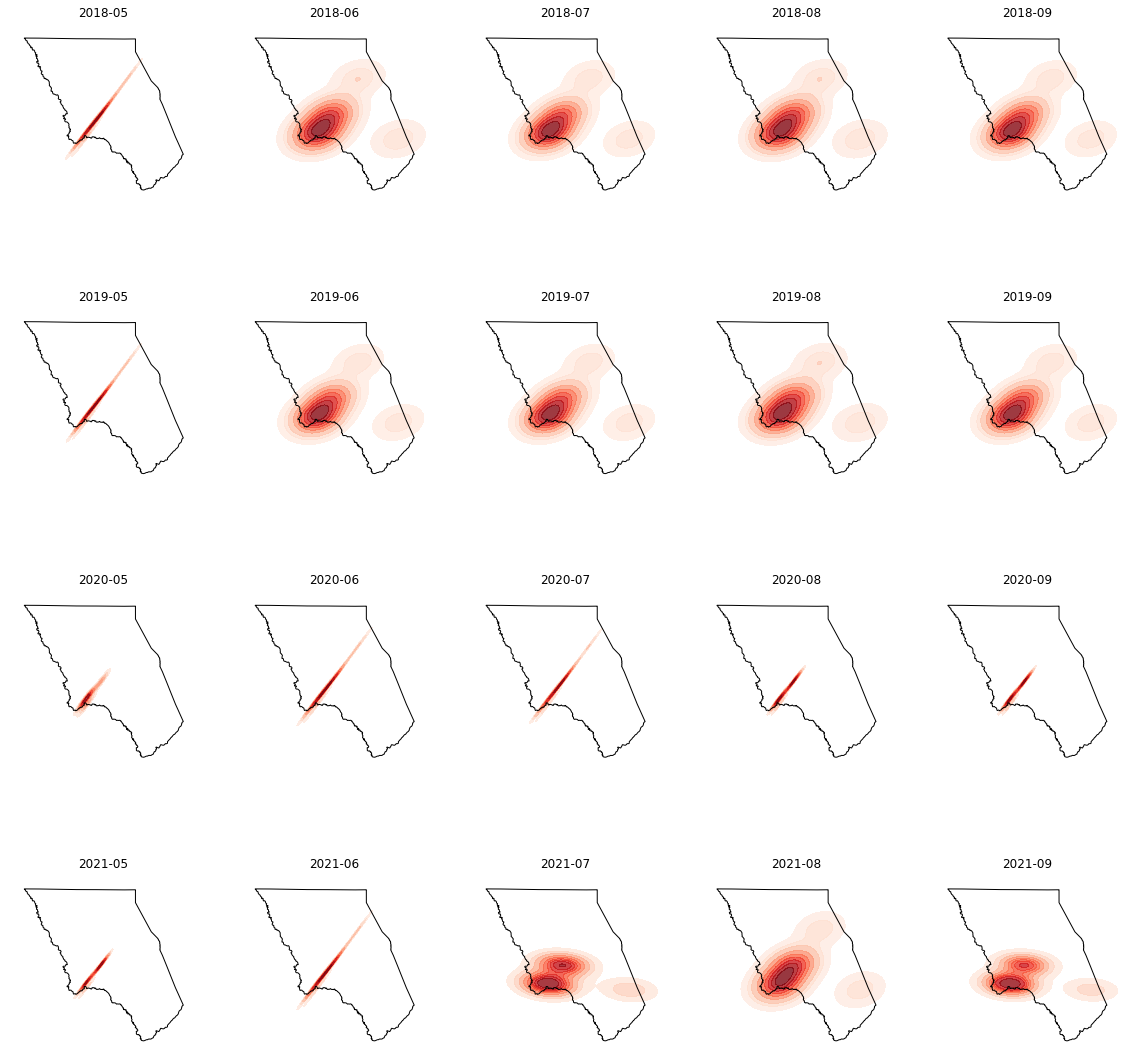

In [27]:
proj = geoplot.crs.AlbersEqualArea(central_latitude = boundary[boundary.index == 'GLAC'].centroid.y[0], 
                                   central_longitude = boundary[boundary.index == 'GLAC'].centroid.x[0])
months = temp['date_range_start'].unique()

plt.figure(figsize = (20, 20))

for idx, month in enumerate(months):

    ax = plt.subplot(4, 5, idx + 1, projection = proj)
    geoplot.kdeplot(temp[temp['date_range_start'] == month], 
                    # clip = boundary[boundary.index == 'GLAC'].geometry,
                    shade = True, 
                    cmap = 'Reds', 
                    #thresh = 0.2, 
                    levels = 10,
                    alpha = 0.8, 
                    projection = proj,
                    #cbar = True,
                    vmin = 0, 
                    #vmax = 309,
                    ax = ax)
    geoplot.polyplot(boundary[boundary.index == 'GLAC'], ax = ax, zorder = 1)
    ax.set_title(month.astype('datetime64[M]')) # convert to year-month

## 3. Road network analysis
- Input: 
    - GeoJSON file that contains POIs found within the Glacier park boundary  (`GeoJSON`)
    - Park boundary (`nps_boundary.shp`)
    - Geo-locations of park's entrance stations(`entrance_coord.csv`)
- Tasks: temporal aggregation, merging
- Results: 
    - A time series plot comparing two data sources
    - A density plot to gauge the spatial dynamics

In [2]:
from IPython.display import Image
from IPython.display import HTML

Specify the unit code of the park, then load cleaned GeoJSON file and park boundary shapefile:

In [3]:

# cleaned Safegraph data at POI level
subset_gdf = gpd.read_file(f"../clean_data/POI_GLAC.geojson")
# park boundary
boundary = gpd.read_file('../raw_data/nps_boundary/nps_boundary.shp')
boundary = boundary.set_index('UNIT_CODE')

Load entrance station info:

In [14]:
entry = pd.read_csv(f'../raw_data/entrance_coord.csv')
# split by "," to create lontitude and latitude columns
lat = []
lon = []

for row in entry['lat_lon']:
    lat.append(row.split(',')[0]) # Split the row by comma and append
    lon.append(row.split(',')[1])
        
# Create two new columns from lat and lon
entry['lat'] = lat
entry['lon'] = lon

In [37]:
# convert to geodataframe
entry_gdf = gpd.GeoDataFrame(entry, 
                             crs = "EPSG:4269",
                             geometry = gpd.points_from_xy(entry.lon, entry.lat))
# filter the entrance stations for that park
entry_gdf = entry_gdf[entry_gdf.unitCode == park].reset_index(drop = True) 
entry_gdf

unitCode   entrance                                 lat_lon  \
0     YELL      North  45.02533214022773, -110.70077613702115   
1     YELL       West  44.65675734348095, -111.08988553970507   
2     YELL      South  44.135784033296666, -110.6668290906966   
3     YELL       East  44.48859569172154, -110.00387389836672   
4     YELL  Northeast   45.00452938664046, -110.0104131407937   

                  lat                   lon                     geometry  
0   45.02533214022773   -110.70077613702115  POINT (-110.70078 45.02533)  
1   44.65675734348095   -111.08988553970507  POINT (-111.08989 44.65676)  
2  44.135784033296666    -110.6668290906966  POINT (-110.66683 44.13578)  
3   44.48859569172154   -110.00387389836672  POINT (-110.00387 44.48860)  
4   45.00452938664046    -110.0104131407937  POINT (-110.01041 45.00453)

### (1) For parks with convex shape (Glacier, Yellowstone, Smokies), it's ideal to buffer around the park boudary and use this buffer to query osm road network

In [6]:
# To create buffer, need to first project to UTM (unit: meters)
buff = boundary.loc[[park]].to_crs(epsg = 26912).buffer(8000) # For Glacier: NAD83 / UTM zone 12N
buff = gpd.GeoDataFrame(geometry = gpd.GeoSeries(buff))
buff

geometry
UNIT_CODE                                                   
YELL       POLYGON ((484360.252 4981509.974, 484359.133 4...

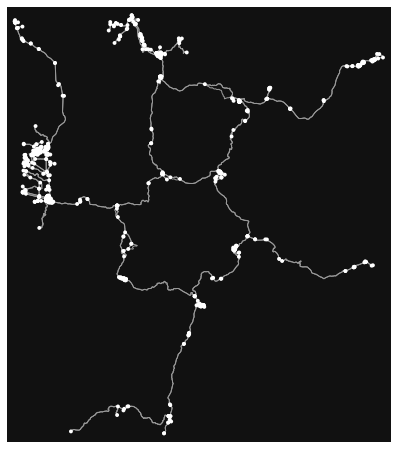

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [7]:
# create network from that buffer
G = ox.graph_from_polygon(buff.to_crs(epsg = 4326).geometry[0], network_type = 'drive', simplify = True)
# Reproject
G = ox.project_graph(G, to_crs = 'epsg:4269')
ox.plot_graph(G)

In [8]:
nodes, edges = ox.graph_to_gdfs(G, nodes = True, edges = True, node_geometry = True)
edges.head()

osmid       highway  \
u         v         key                                                   
158216425 465785452 0    [269330292, 39058700, 269330294]  unclassified   
          465805251 0    [106471688, 82809818, 106471684]  unclassified   
          158216521 0                           269330285  unclassified   
465785452 158216425 0    [269330292, 39058700, 269330294]  unclassified   
465805251 465805245 0                            39061386  unclassified   

                         oneway     length bridge  \
u         v         key                             
158216425 465785452 0     False    376.615    yes   
          465805251 0     False  16791.272    yes   
          158216521 0     False   1502.607    NaN   
465785452 158216425 0     False    376.615    yes   
465805251 465805245 0     False     55.218    NaN   

                                                                  geometry  \
u         v         key                                                      
158216425 465785452 0    LINESTRING (-110.81707 44.13179, -110.81741 44...   
          465805251 0    LINESTRING (-110.81707 44.13179, -110.81689 44...   
          158216521 0    LINESTRING (-110.81707 44.13179, -110.81714 44...   
465785452 158216425 0    LINESTRING (-110.82061 44.13143, -110.82051 44...   
465805251 465805245 0    LINESTRING (-110.67317 44.10727, -110.67314 44...   

                                     name lanes  ref maxspeed tunnel access  \
u         v         key                                                       
158216425 465785452 0                 NaN   NaN  NaN      NaN    NaN    NaN   
          465805251 0    Grassy Lake Road   NaN  NaN      NaN    NaN    NaN   
          158216521 0    Grassy Lake Road   NaN  NaN      NaN    NaN    NaN   
465785452 158216425 0                 NaN   NaN  NaN      NaN    NaN    NaN   
465805251 465805245 0                 NaN   NaN  NaN      NaN    NaN    NaN   

                        width  
u         v         key        
158216425 465785452 0     NaN  
          465805251 0     NaN  
          158216521 0     NaN  
465785452 158216425 0     NaN  
465805251 465805245 0     NaN

### (2) For parks with concave shape (Zion and Acadia), better to use the bounding box instead of a buffer.

In [9]:
# # create bounding box based on park boundary
# bound = boundary.loc[[park]].total_bounds  
# # Specify the coordinates of four bounds
# north, south, east, west = bound[3], bound[1], bound[2], bound[0]
# # create network from that bounding box
# G = ox.graph_from_bbox(north, south, east, west, network_type = 'drive', simplify = True)
# ox.plot_graph(G)

### Choose a date that we would like to study: the purpose is to compare the congestion conditions between the same time period of different years, such as the first Friday of August in 2018 vs. 2020.

In [70]:
subset_gdf.head()

date_range_start date_range_end             placekey  \
0  2020-06-01T00:00:00     2020-07-01  zzy-222@5wf-jgg-7t9   
1  2020-06-01T00:00:00     2020-07-01  zzy-222@5wf-jgg-7t9   
2  2020-06-01T00:00:00     2020-07-01  zzy-222@5wf-jgg-7t9   
3  2020-06-01T00:00:00     2020-07-01  zzy-222@5wf-jgg-7t9   
4  2020-06-01T00:00:00     2020-07-01  zzy-222@5wf-jgg-7t9   

  sg_c__parent_placekey sg_c__location_name sg_c__safegraph_brand_ids  \
0                  None   The Boiling River                      None   
1                  None   The Boiling River                      None   
2                  None   The Boiling River                      None   
3                  None   The Boiling River                      None   
4                  None   The Boiling River                      None   

  sg_c__brands sg_c__top_category      sg_c__sub_category  sg_c__naics_code  \
0         None   Spectator Sports  Sports Teams and Clubs          711211.0   
1         None   Spectator Sports  Sports Teams and Clubs          711211.0   
2         None   Spectator Sports  Sports Teams and Clubs          711211.0   
3         None   Spectator Sports  Sports Teams and Clubs          711211.0   
4         None   Spectator Sports  Sports Teams and Clubs          711211.0   

   sg_c__latitude  sg_c__longitude sg_c__street_address sg_c__city  \
0       44.992398      -110.691908               Hwy 89   Gardiner   
1       44.992398      -110.691908               Hwy 89   Gardiner   
2       44.992398      -110.691908               Hwy 89   Gardiner   
3       44.992398      -110.691908               Hwy 89   Gardiner   
4       44.992398      -110.691908               Hwy 89   Gardiner   

  sg_c__region  sg_c__postal_code sg_c__iso_country_code  sg_c__phone_number  \
0           MT            59030.0                     US                 NaN   
1           MT            59030.0                     US                 NaN   
2           MT            59030.0                     US                 NaN   
3           MT            59030.0                     US                 NaN   
4           MT            59030.0                     US                 NaN   

  sg_c__open_hours sg_c__category_tags sg_c__opened_on sg_c__closed_on  \
0             None                None            None            None   
1             None                None            None            None   
2             None                None            None            None   
3             None                None            None            None   
4             None                None            None            None   

  sg_c__tracking_closed_since sg_c__geometry_type sg_mp__parent_placekey  \
0                  2019-07-01             POLYGON                   None   
1                  2019-07-01             POLYGON                   None   
2                  2019-07-01             POLYGON                   None   
3                  2019-07-01             POLYGON                   None   
4                  2019-07-01             POLYGON                   None   

  sg_mp__location_name sg_mp__street_address sg_mp__city sg_mp__region  \
0    The Boiling River                Hwy 89    Gardiner            mt   
1    The Boiling River                Hwy 89    Gardiner            mt   
2    The Boiling River                Hwy 89    Gardiner            mt   
3    The Boiling River                Hwy 89    Gardiner            mt   
4    The Boiling River                Hwy 89    Gardiner            mt   

   sg_mp__postal_code sg_mp__safegraph_brand_ids sg_mp__brands  \
0             59030.0                       None          None   
1             59030.0                       None          None   
2             59030.0                       None          None   
3             59030.0                       None          None   
4             59030.0                       None          None   

     sg_mp__date_range_start      sg_mp__date_range_end  \
0  2020-06-01T

In [69]:
subset_gdf['date'].dtypes

dtype('<M8[ns]')

In [68]:
day = '2018-08-02'

# convert string to datetime
subset_gdf['date'] = pd.DatetimeIndex(subset_gdf.date)
# convert to numeric
subset_gdf['sg_mp__visits_by_day'] = pd.to_numeric(subset_gdf['sg_mp__visits_by_day']) 
poi_gdf = subset_gdf.loc[subset_gdf['date'] == day, 
                         ['placekey', 'date', 'sg_c__location_name', 'geometry', 'sg_mp__visits_by_day']].reset_index(drop = True)
poi_gdf

placekey       date                       sg_c__location_name  \
0   zzy-222@5wf-jgg-7t9 2018-08-02                         The Boiling River   
1   222-222@5wg-hzm-28v 2018-08-02  Delaware North Park Srvcs At Yellowstone   
2   zzy-222@5wg-hzm-99f 2018-08-02                          Montana Workcare   
3   zzy-224@5wg-h6c-6rk 2018-08-02                         Lake Lodge Cabins   
4   zzy-223@5wg-h6c-6rk 2018-08-02         Yellowstone Park Service Stations   
5   zzy-222@5wf-jgc-dvz 2018-08-02         Yellowstone Park Service Stations   
6   zzy-222@5wg-h6c-9s5 2018-08-02                             Obsidian Room   
7   zzy-222@5wg-ky9-t7q 2018-08-02                   Canyon Lodge and Cabins   
8   zzy-222@5wg-mdf-pd9 2018-08-02           Grand Canyon of the Yellowstone   
9   zzy-22h@5wg-k4r-yn5 2018-08-02                      Lake Lodge Cafeteria   
10  zzy-224@5wg-k4r-yn5 2018-08-02                Old Faithful Inn Gift Shop   
11  222-222@5wg-h6c-9cq 2018-08-02                              Geyser Grill   
12  zzy-222@5wg-h3w-f75 2018-08-02                             Biscuit Basin   
13  zzy-222@5wg-gzk-54v 2018-08-02         Yellowstone Park Service Stations   
14  zzy-225@5wg-h6c-6rk 2018-08-02                        Fountain Paint Pot   
15  zzy-226@5wg-k4r-yn5 2018-08-02                    Canyon Lodge Cafeteria   
16  222-222@5wg-k4h-28v 2018-08-02              Fishing Bridge General Store   
17  zzy-222@5wg-mc4-9xq 2018-08-02                       Xanterra Trail Ride   
18  zzw-222@5wg-kxr-fpv 2018-08-02                               Mt Washburn   
19  zzy-222@5wg-h6c-9mk 2018-08-02      Yellowstone Art & Photography Center   
20  zzy-222@5wg-mc2-gx5 2018-08-02                   Old West Dinner Cookout   
21  zzy-222@5wg-k4h-28v 2018-08-02         Yellowstone Park Service Stations   
22  zzw-224@5wg-h6c-6rk 2018-08-02                             Hayden Valley   
23  zzy-222@5wf-jg9-qpv 2018-08-02            Little Peoples Learning Center   
24  zzy-227@5wg-h6c-6rk 2018-08-02          Yellowstone National Park Lodges   
25  zzy-222@5wg-ky6-dqf 2018-08-02                Yellowstone General Stores   
26  zzy-222@5wg-h6m-brk 2018-08-02                          Hamilton's Store   
27  zzy-222@5wg-ky9-tn5 2018-08-02                        Canyon Bar & Grill   
28  zzy-222@5wg-jqb-mhq 2018-08-02                              Old Faithful   
29  zzw-222@5wg-h6c-6rk 2018-08-02                              Old Faithful   
30  zzy-222@5wg-k4r-yy9 2018-08-02                           Lake Hotel Deli   
31  zzy-22b@5wg-k4r-yn5 2018-08-02                       Grant Village Lodge   
32  zzy-222@5wg-mf7-pjv 2018-08-02                         Uncle Tom's Trail   
33  zzw-222@5wf-jgj-nt9 2018-08-02            Fort Yellowstone Army Cemetery   
34  zzy-222@5wg-hq9-fpv 2018-08-02                  Grant Village Campground   
35  zzy-222@5wg-hqb-fxq 2018-08-02                       Norris Geyser Basin   
36  zzy-222@5wg-ky9-skf 2018-08-02                              Canyon Lodge   
37  zzy-222@5wg-mcd-89z 2018-08-02                               Tower Falls   
38  zzy-227@5wg-k4r-yn5 2018-08-02                         Canyon Lodge Deli   
39  zzy-222@5wg-mhm-6kz 2018-08-02                       Norris Geyser Basin   
40  zzw-222@5wg-h4p-tsq 2018-08-02                       Firehole Lake Drive   
41  zzy-222@5wg-jpc-85f 2018-08-02                                   Madison   
42  zzy-222@5wg-k4r-kxq 2018-08-02                                   Lake WY   
43  zzy-22b@5wg-h6c-6rk 2018-08-02                                Bear Aware   
44  zzy-229@5wg-h6c-6rk 2018-08-02  Delaware North Park Srvcs At Yellowstone   
45  zzy-222@5wf-jgj-sqz 2018-08-02                 Yellowstone General Store   

                       geometry  sg_mp__visits_by_day  
0   POINT (-110.69191 44.99240)                     7  
1   POINT (-111.09055 44.65505)                     4  
2   POINT (-111.09594 44.65677)                     0  
3   POINT (-110.57477 44.41549

Plot entrance stations (start) and POIs (end) together with the park road network:

In [59]:
m = edges[edges.highway == 'secondary'].explore()
poi_gdf.drop(['date'], axis = 1).explore(m = m, 
                                         column = 'sg_mp__visits_by_day', 
                                         cmap = "RdBu_r",
                                         marker_type = 'circle',
                                         marker_kwds = {'radius': 1000,
                                                        'fill': True
                                                       }
                                        ) # POIs
entry_gdf.explore(m = m, 
                  marker_type = 'marker'
                 ) # entrances

In [33]:
# A function helps you to find the nearest OSM node from a given GeoDataFrame
def find_nearest_osm(network, gdf):
    """
    # This function helps you to find the nearest OSM node from a given GeoDataFrame
    # If geom type is point, it will take it without modification, but 
    # IF geom type is polygon or multipolygon, it will take its centroid to calculate the nearest element. 
    
    Input: 
    - network (NetworkX MultiDiGraph): Network Dataset obtained from OSMnx
    - gdf (GeoDataFrame): stores locations in its `geometry` column 
    
    Output:
    - gdf (GeoDataFrame): will have `nearest_osm` column, which describes the nearest OSM node 
                          that was computed based on its geometry column
      
    """
    for idx, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
        if row.geometry.geom_type == 'Point':
            nearest_osm = ox.distance.nearest_nodes(network, 
                                                    X=row.geometry.x, 
                                                    Y=row.geometry.y
                                                   )
        elif row.geometry.geom_type == 'Polygon' or row.geometry.geom_type == 'MultiPolygon':
            nearest_osm = ox.distance.nearest_nodes(network, 
                                        X=row.geometry.centroid.x, 
                                        Y=row.geometry.centroid.y
                                       )
        else:
            print(row.geometry.geom_type)
            continue

        gdf.at[idx, 'nearest_osm'] = nearest_osm

    return gdf

In [34]:
poi_gdf = find_nearest_osm(G, poi_gdf)
poi_gdf

100%|█████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 173.97it/s]


placekey       date                       sg_c__location_name  \
0   zzy-222@5wf-jgg-7t9 2018-08-02                         The Boiling River   
1   222-222@5wg-hzm-28v 2018-08-02  Delaware North Park Srvcs At Yellowstone   
2   zzy-222@5wg-hzm-99f 2018-08-02                          Montana Workcare   
3   zzy-224@5wg-h6c-6rk 2018-08-02                         Lake Lodge Cabins   
4   zzy-223@5wg-h6c-6rk 2018-08-02         Yellowstone Park Service Stations   
5   zzy-222@5wf-jgc-dvz 2018-08-02         Yellowstone Park Service Stations   
6   zzy-222@5wg-h6c-9s5 2018-08-02                             Obsidian Room   
7   zzy-222@5wg-ky9-t7q 2018-08-02                   Canyon Lodge and Cabins   
8   zzy-222@5wg-mdf-pd9 2018-08-02           Grand Canyon of the Yellowstone   
9   zzy-22h@5wg-k4r-yn5 2018-08-02                      Lake Lodge Cafeteria   
10  zzy-224@5wg-k4r-yn5 2018-08-02                Old Faithful Inn Gift Shop   
11  222-222@5wg-h6c-9cq 2018-08-02                              Geyser Grill   
12  zzy-222@5wg-h3w-f75 2018-08-02                             Biscuit Basin   
13  zzy-222@5wg-gzk-54v 2018-08-02         Yellowstone Park Service Stations   
14  zzy-225@5wg-h6c-6rk 2018-08-02                        Fountain Paint Pot   
15  zzy-226@5wg-k4r-yn5 2018-08-02                    Canyon Lodge Cafeteria   
16  222-222@5wg-k4h-28v 2018-08-02              Fishing Bridge General Store   
17  zzy-222@5wg-mc4-9xq 2018-08-02                       Xanterra Trail Ride   
18  zzw-222@5wg-kxr-fpv 2018-08-02                               Mt Washburn   
19  zzy-222@5wg-h6c-9mk 2018-08-02      Yellowstone Art & Photography Center   
20  zzy-222@5wg-mc2-gx5 2018-08-02                   Old West Dinner Cookout   
21  zzy-222@5wg-k4h-28v 2018-08-02         Yellowstone Park Service Stations   
22  zzw-224@5wg-h6c-6rk 2018-08-02                             Hayden Valley   
23  zzy-222@5wf-jg9-qpv 2018-08-02            Little Peoples Learning Center   
24  zzy-227@5wg-h6c-6rk 2018-08-02          Yellowstone National Park Lodges   
25  zzy-222@5wg-ky6-dqf 2018-08-02                Yellowstone General Stores   
26  zzy-222@5wg-h6m-brk 2018-08-02                          Hamilton's Store   
27  zzy-222@5wg-ky9-tn5 2018-08-02                        Canyon Bar & Grill   
28  zzy-222@5wg-jqb-mhq 2018-08-02                              Old Faithful   
29  zzw-222@5wg-h6c-6rk 2018-08-02                              Old Faithful   
30  zzy-222@5wg-k4r-yy9 2018-08-02                           Lake Hotel Deli   
31  zzy-22b@5wg-k4r-yn5 2018-08-02                       Grant Village Lodge   
32  zzy-222@5wg-mf7-pjv 2018-08-02                         Uncle Tom's Trail   
33  zzw-222@5wf-jgj-nt9 2018-08-02            Fort Yellowstone Army Cemetery   
34  zzy-222@5wg-hq9-fpv 2018-08-02                  Grant Village Campground   
35  zzy-222@5wg-hqb-fxq 2018-08-02                       Norris Geyser Basin   
36  zzy-222@5wg-ky9-skf 2018-08-02                              Canyon Lodge   
37  zzy-222@5wg-mcd-89z 2018-08-02                               Tower Falls   
38  zzy-227@5wg-k4r-yn5 2018-08-02                         Canyon Lodge Deli   
39  zzy-222@5wg-mhm-6kz 2018-08-02                       Norris Geyser Basin   
40  zzw-222@5wg-h4p-tsq 2018-08-02                       Firehole Lake Drive   
41  zzy-222@5wg-jpc-85f 2018-08-02                                   Madison   
42  zzy-222@5wg-k4r-kxq 2018-08-02                                   Lake WY   
43  zzy-22b@5wg-h6c-6rk 2018-08-02                                Bear Aware   
44  zzy-229@5wg-h6c-6rk 2018-08-02  Delaware North Park Srvcs At Yellowstone   
45  zzy-222@5wf-jgj-sqz 2018-08-02                 Yellowstone General Store   

                       geometry  sg_mp__visits_by_day   nearest_osm  
0   POINT (-110.69191 44.99240)                     7  2.611856e+08  
1   POINT (-111.09055 44.65505)                     4  1.209407e+09  
2   POINT (-111.09594 44.65677)             

In [38]:
entry_gdf = find_nearest_osm(G, entry_gdf)
entry_gdf

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 143.15it/s]


unitCode   entrance                                 lat_lon  \
0     YELL      North  45.02533214022773, -110.70077613702115   
1     YELL       West  44.65675734348095, -111.08988553970507   
2     YELL      South  44.135784033296666, -110.6668290906966   
3     YELL       East  44.48859569172154, -110.00387389836672   
4     YELL  Northeast   45.00452938664046, -110.0104131407937   

                  lat                   lon                     geometry  \
0   45.02533214022773   -110.70077613702115  POINT (-110.70078 45.02533)   
1   44.65675734348095   -111.08988553970507  POINT (-111.08989 44.65676)   
2  44.135784033296666    -110.6668290906966  POINT (-110.66683 44.13578)   
3   44.48859569172154   -110.00387389836672  POINT (-110.00387 44.48860)   
4   45.00452938664046    -110.0104131407937  POINT (-110.01041 45.00453)   

    nearest_osm  
0  2.820026e+09  
1  8.782759e+08  
2  4.657851e+08  
3  1.209243e+09  
4  1.199257e+09

In [39]:
routes = nx.shortest_path(G = G, 
                          source = entry_gdf.loc[0, 'nearest_osm'], 
                          target = poi_gdf.loc[0, 'nearest_osm'], 
                          weight = 'length',
                          method = 'dijkstra'
                         )
routes # From Jammer Joe's Grill and Pizzeria to West Entrance

[2820025556.0, 261185594]

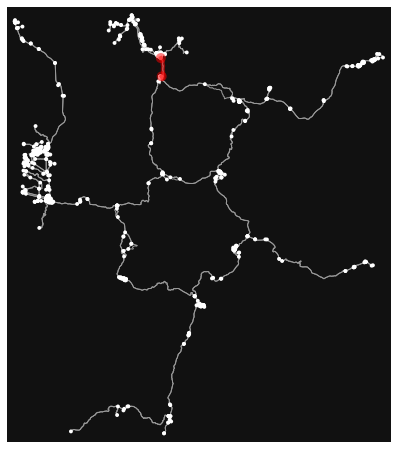

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [40]:
ox.plot.plot_graph_route(G, routes)

### Calculate the times that each edges has been passed through by visitors _on that day_:

In [41]:
edges['travel_times'] = 0

for idx_p, row_p in poi_gdf.iterrows():
    length = []
    for idx_e, row_e in entry_gdf.iterrows():
        temp_length = nx.shortest_path_length(G = G, 
                                  source = row_e['nearest_osm'], 
                                  target = row_p['nearest_osm'], 
                                  weight = 'length',
                                  method = 'dijkstra'
                                 )
        length.append(temp_length)
    
    # get the position in the list with smallest distance
    val, idx = min((val, idx) for (idx, val) in enumerate(length)) 
    
    # from entrance to POI
    start_route = nx.shortest_path(G = G, 
                                   source = entry_gdf.loc[idx, 'nearest_osm'], 
                                   target = row_p['nearest_osm'], 
                                   weight = 'length',
                                   method = 'dijkstra'
                                  )
    
    for i in range(len(start_route) - 1):
        cum_sum = edges.loc[(edges.index.get_level_values('u') == start_route[i]) & (edges.index.get_level_values('v') == start_route[i+1]), 'travel_times'] + row_p['sg_mp__visits_by_day']
        edges.loc[(edges.index.get_level_values('u') == start_route[i]) & (edges.index.get_level_values('v') == start_route[i+1]), 'travel_times'] = cum_sum
    
    # from POI to entrance
    back_route = nx.shortest_path(G = G, 
                                  source = row_p['nearest_osm'], 
                                  target = entry_gdf.loc[idx, 'nearest_osm'], 
                                  weight = 'length',
                                  method = 'dijkstra'
                                 )
    
    for i in range(len(back_route) - 1):
        cum_sum = edges.loc[(edges.index.get_level_values('u') == back_route[i]) & (edges.index.get_level_values('v') == back_route[i+1]), 'travel_times'] + row_p['sg_mp__visits_by_day']
        edges.loc[(edges.index.get_level_values('u') == back_route[i]) & (edges.index.get_level_values('v') == back_route[i+1]), 'travel_times'] = cum_sum

In [61]:
# check summary statistiscs
edges.travel_times.describe() 

count    1935.000000
mean        8.136951
std        35.527206
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       265.000000
Name: travel_times, dtype: float64

In [60]:
# check edges with nonzero entries
edges[edges['travel_times'] != 0] 

osmid  \
u          v          key                                                      
40840045   158199493  0                      [5545947, 453257574, 104870991]   
           40840049   0                     [74272380, 492206886, 492206887]   
158199493  1209409098 0                                 [15780645, 15780646]   
           40840045   0                      [5545947, 453257574, 104870991]   
40840049   878275942  0                     [492206888, 492206889, 74272378]   
878275942  40840045   0                                            492206889   
           1209407540 0                                [74272376, 104871057]   
158145409  1209476034 0         [104883377, 104932466, 105953484, 353623054]   
           158191828  0    [403445889, 403445890, 104894482, 353623060, 3...   
1209476034 158190269  0                    [104856493, 104883365, 104883375]   
           158145409  0         [104883377, 104932466, 105953484, 353623054]   
                      1                                            403445885   
158191828  158145409  0    [403445889, 403445890, 104894482, 353623060, 3...   
           4254680404 0          [27750361, 104894482, 27749909, 1018319170]   
158149120  158151610  0                                             15779198   
           1209890963 0                                 [23682881, 15777765]   
158151610  256441120  0                                             15778131   
           2877165601 0                                            106211038   
1209890963 158165174  0                                             23682881   
256441120  158151610  0                                             15778131   
2877165601 256439183  0                                            104932517   
158165163  158165190  0                                            103875089   
158165190  158165163  0                                            103875089   
           158165181  0                                            908875840   
158165174  158165181  0                                             15778636   
           158165190  0                                             23682881   
158165181  1209890740 0                                [908875840, 23682208]   
1209890740 158151610  0                                [23682208, 106211038]   
158190269  1209406578 0          [108967130, 15780875, 353675124, 104871126]   
           1209476034 0                    [104883375, 104856493, 104883365]   
1209406578 1209409098 0                    [104871120, 104871126, 104870991]   
           158190269  0          [108967130, 15780875, 353675124, 104871126]   
158191622  4968896794 0            [27749937, 27749818, 23681963, 105953483]   
           256438060  0                                             23682059   
4968896794 158191764  0                                             27749937   
           158191622  0            [27749937, 27749818, 105953483, 23681963]   
256438060  2877164100 0                     [23682171, 288867468, 288867469]   
158191764  158191774  0    [27749898, 27749899, 15782554, 361642619, 3616...   
                      1                                [27749937, 105953476]   
           4968896794 0                                             27749937   
158191774  4254680404 0                                            105953476   
           158191764  0                                [27749937, 105953476]   
4254680404 158191774  0                                            105953476   
                      1                                [27749906, 426161317]   
           158191828  0          [27750361, 1018319170, 104894482, 27749909]   
1209409098 158199493  0                                 [15780645, 15780646]   
           1209406578 0                    [104871120, 104871126, 104870991]   
2877164100 158149120  0                                             15777765   
256439183  158191622  0                                             236

### Let's color code edges based on the number of visitors that may have passed through each each road segment, using Red/Yellow/Green palettes:

In [64]:
m = edges.explore(tiles = 'Stamen Terrain',
              column = 'travel_times', 
              cmap = 'RdYlGn_r',
              scheme = 'NaturalBreaks',
              k = 5,
              vmin = 0,
              highlight = True,
              tooltip = ['name', 'travel_times'], # displayed upon hovering
              popup = True, # all columns displayed upon clicking
              legend_kwds = {
                  'caption': 'Congestion',
                  'scale': False,
                  'colorbar': False
              }
             )
entry_gdf.explore(m = m, 
                  marker_type = 'marker',
                  tooltip = ['entrance']
                 ) # entrances

In [67]:
m.save(f"../map/netwrok_{park}_{day}.html")